In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);

</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import dask.dataframe as dd
import dask.bag as db
import dask.array as da
import dask.dataframe as dd

# pd.set_option('display.max_colwidth', None)
# import warnings
# warnings.filterwarnings("ignore")


import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

from sklearn import tree
from IPython.display import Image

warnings.filterwarnings("ignore", category=Warning)

<img src="https://i.ibb.co/7X2sdvR/header.jpg" alt="header" border="0">

# Do the Doodle: Predicting "Quick, Draw!" drawings based on player's first drawing stroke

EC Corro | SS Garcia | J Gonzales | CR Patalud 

<div><span style="background-color: #1F773B; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #F2FBF5; font-size: 20px; font-weight: bold">EXECUTIVE SUMMARY</span></div>

**"Quick Draw!"** is an online game developed by Google Creative Lab that guesses the drawing as the player draws the given image. It was observed that majority of the sketches were guessed after the second stroke, but the game may need up to more than 10 strokes before being guessed correctly. It was also found that within the dataset, only 12.01% of the sketches were guessed upon completion of the first stroke. With this, this study aims to answer the question: **Can Quick, Draw! sketches be identified given only the first stroke?**. 

The Quick Draw! dataset used was obtained from Kaggle with size of 53.1 GB of data composed of 36 million drawings under 82 categories. 

Our methodology involves data preprocessing using the AWS platform and use of dask library functions, exploratory data analysis and model development. We developed two models, (1) without grouping and (2) with grouping which places those that have an f-1 score of less than 0.3 in a single group.

Our results show that for without and with grouping, we obtained accuracy of 25.13% and 75.19%, This is higher than the computed 1.25xPCC of 2.11% and 68.13%. Comparing this to Quick Draws AI!'s performance in guessing sketches correctly after the first at 12.01%, our models were able to outperform this even without grouping at 25.13%.

In conclusion, the model can be integrated to Quick, Draw!’s underlying neural network to improve its speed in guessing a sketch. For future studies, we recommend the following:
1. Expand the dataset by using other categories on the original dataset.
2. Use of different neural networks as model architectures might improve the model's performance.
3. Aside from prediction, auto completion of sketches can be explored.

This study will be valuable in the future of sketch prediction. We imagine using a single sketch as an input that would prompt possible recommendations to the user. Additionally, with the increasing use of smart phones and touch devices, this will also be useful to educators and students by speeding up the sketching process and focusing more on the lesson at hand.

<div><span style="background-color: #1F773B; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #F2FBF5; font-size: 20px; font-weight: bold">INTRODUCTION</span></div>


The **Quick, Draw!** game is a game invented by Jonas Jongejan, Henry Rowley, Takashi Kawashima, Jongmin Kim, Nick Fox-Gieg, of the Google Creative Lab$^1$. A player is given a maximum of 20 seconds to draw an object such as apple, zebra, clock, or paper clip. The game relies on the data provided by previous players to learn more about the objects being drawn. One important feature of these sketches is the drawing stroke, which is defined as a continuous line before lifting the pen or writing material. Data on this includes the location and length of the stroke as well as the time it takes to draw the stroke.  

Quick, Draw! utilizes neural networks to quickly guess the object being drawn, and players are amazed at how fast these images are being guessed, sometimes even before the 20 seconds are up, and sometimes even before the sketch is finished. While the Quick, Draw! game shows impressive results as it guesses the objects being drawn, it was found that only 13% of the sketches were guessed upon completion of the first stroke. Majority of the sketches were guessed after the second stroke but images can take up to more than 10 strokes before being guessed correctly. 

In this study, we aim to answer the question: **Can Quick, Draw! sketches be identified given only the first stroke?** We will explore how the algorithm can be improved to produce faster results, specifically identifying sketches given only the first drawing stroke.

<div><span style="background-color: #1F773B; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #F2FBF5; font-size: 20px; font-weight: bold">DATASET</span></div>

The **Quick Draw!** dataset was obtained from Kaggle$^2$ and was developed by the Google Creative Lab, which has 55 repositories administered by a group of developers, researchers and artists to explore, study and learn from. The raw dataset is a collection of **50 million** drawings across **345 categories** contributed by players of the game. The drawings were captured via timestamped vectors, tagged with metadata including the object to be drawn, and the player's origin.

### Raw Dataset

The raw dataset available is in `csv` format for each category and has the following columns:

|column name|Data Type|Description|
|:--|:--|:--|
|countrycode|String|Country Code where the drawing originated|
|drawing|Array|Drawing array representing the drawing's stroke coordinates and time|
|key_id|String|Unique key ID of the drawing|
|recognized|Boolean|Boolean identification whether the drawing was successfuly recognized by the AI|
|timestamp|Time Object|Timestamp when the object was drawn|
|word|String|The Object Being Drawn by the Participant|

<center><b>Table 1. Raw Dataset Description</b></center>


### Dataset used

From the original dataset of **227 GB** of drawings, we have a preselected dataset composed of **53.1 GB** of data under **82 categories** composed of **36 million sketches** of organic living things. This varies from different types of animals,fruits and other types of living things which can be seen below. This was stored in AWS s3 bucket:`s3://bdccdoodle/drawings_csv`

### Preselected Doodle Dataset are Stored in an S3 bucket `s3://bdccdoodle/drawings_csv`

In [2]:
%%bash
aws s3 ls s3://bdccdoodle/drawings_csv/ --human-readable --summarize 

2021-01-23 12:10:19    0 Bytes 
2021-01-23 12:11:44  383.5 MiB ant.csv
2021-01-23 12:11:44  464.2 MiB apple.csv
2021-01-23 12:11:44  454.7 MiB arm.csv
2021-01-23 12:11:46  667.4 MiB asparagus.csv
2021-01-23 12:11:46  914.6 MiB banana.csv
2021-01-23 12:11:44  618.5 MiB bat.csv
2021-01-23 12:11:46  627.2 MiB bear.csv
2021-01-23 12:11:44  579.2 MiB bee.csv
2021-01-23 12:11:44  567.8 MiB bird.csv
2021-01-23 12:11:46  655.9 MiB blackberry.csv
2021-01-23 12:11:44  375.4 MiB blueberry.csv
2021-01-23 12:11:46  873.4 MiB brain.csv
2021-01-23 12:11:46  633.0 MiB broccoli.csv
2021-01-23 12:11:44  550.3 MiB butterfly.csv
2021-01-23 12:11:44  498.3 MiB carrot.csv
2021-01-23 12:11:44  565.5 MiB cat.csv
2021-01-23 12:11:46  853.5 MiB cow.csv
2021-01-23 12:11:46  718.5 MiB crab.csv
2021-01-23 12:11:46  740.1 MiB crocodile.csv
2021-01-23 12:11:46  778.5 MiB dog.csv
2021-01-23 12:11:44  535.3 MiB dolphin.csv
2021-01-23 12:11:47    1.3 GiB duck.csv
2021-01-23 12:11:44  288.5 MiB ear.csv
2021-01-23 12:11:

<div><span style="background-color: #1F773B; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #F2FBF5; font-size: 20px; font-weight: bold">METHODOLOGY</span></div>

Our methodology involves the following steps:


<img src="https://i.ibb.co/GMc3Bj4/method-trans.png" alt="method-trans" border="0">

<center><b>Figure 1. Overall Methodology of the project.</b></center>

## 1. Data Preprocessing

From the preselected Doodle dataset stored in the S3 bucket, we used the dask library functions in preprocessing this big amount of data. We used the cloud thru the Amazon Web Services (AWS) platform to address the memory limitation when processing on our local computers.

In the preprocessing stage, since we are after predicting the sketch after the first stroke, we extracted only the coordinates of the first stroke of each sketch. We then separated its x and y coordinates and used these as features. We also computed and added `stroke_num` and `stroke _length` columns. All of the data precprocessing methods can be found in the `Data Preprocessing.ipynb` notebook attached. 

The final dataset used in this study can be found below after the data description:




|column name|Data Type|Description|
|:--|:--|:--|
|countrycode|String|Country Code where the drawing originated|
|recognized|Boolean|Boolean identification whether the drawing was successfuly recognized by the AI|
|word|String|The Object Being Drawn by the Participant|
|stroke_num|Integer|Total Number of Strokes|
|stroke_length|Integer|Length of the first stroke extracted|
|x_n|Integer|x coordinates of the first stroke|
|y_n|Integer|y coordinates of the first stroke|

<center><b>Table 2. Final Dataset Description.</b></center>

In [3]:
df2 = dd.read_csv('s3://bdcc-doodle/draw_processed_csv/draw_processed_*.csv')

In [18]:
df = df2.compute()
df

,countrycode,recognized,word,stroke_num,stroke_length,x_0,x_1,x_2,x_3,x_4,...,y_76,y_77,y_78,y_79,y_80,y_81,y_82,y_83,y_84,y_85
0,US,1,ant,11,106,970,965,960,955,950,...,477,476,475,472,469,466,463,460,455,450
1,IT,0,ant,2,682,1460,1456,1453,1449,1446,...,1609,1621,1634,1643,1656,1673,1690,1707,1724,1737
2,US,1,ant,7,95,344,339,332,327,321,...,193,193,193,193,193,193,193,193,193,195
3,ID,1,ant,12,299,707,704,699,694,689,...,292,287,282,277,276,276,280,285,291,296
4,PT,1,ant,8,86,898,893,885,880,871,...,350,350,350,350,350,350,350,350,350,350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853934,GB,1,zebra,6,200,369,358,352,344,339,...,385,380,372,361,352,344,336,333,338,346
3853935,RU,1,zebra,22,264,383,389,395,401,410,...,489,489,489,490,491,491,491,491,491,491
3853936,NL,0,zebra,14,262,490,485,480,473,467,...,391,401,411,419,425,434,438,438,438,438
3853937,US,1,zebra,7,333,296,289,284,276,268,...,483,474,462,450,436,422,407,393,378,359


## 2. Exploratory Data Analysis

### Recognized Drawings based on first stroke

We determined the number of successfully recognized drawings based on the first stroke in the dataset. It was found that only **12.01%** of the total drawings were identified correctly after the first stroke. 

In [5]:
df1 = dd.read_csv('s3://bdccdoodle/drawings_csv/*.csv', 
                  error_bad_lines=False,
                  storage_options={'anon':True}, 
                  dtype={'drawing': 'object'})

#Getting the number of strokes
def get_num_strokes(data):
    """Return num_strokes set of stroke elements x, y, t coordinates in string
    format.
    """
    data = data[1:-1]
    x = data.split(']], ')
    x[-1] = x[-1][:-2]
    x = [st + ']]' for st in x]  
    return len(x)

df1['stroke_num'] = df1.drawing.apply(lambda x: get_num_strokes(x))

In [8]:
df1[df1.recognized==True].stroke_num.value_counts()

Dask Series Structure:
npartitions=1
    int64
      ...
Name: stroke_num, dtype: int64
Dask Name: value-counts-agg, 8532 tasks

In [9]:
df1.stroke_num.value_counts() #.compute()

Dask Series Structure:
npartitions=1
    int64
      ...
Name: stroke_num, dtype: int64
Dask Name: value-counts-agg, 5733 tasks

In [8]:
df['stroke_num'] = df.drawing.apply(lambda x: get_num_strokes(x))

In [17]:
recog = df[df.recognized==True].stroke_num.value_counts().compute()
recog

2       1439292
1       1326364
3       1277968
4       1091552
5       1053631
         ...   
93            1
89            1
88            1
86            1
1847          1
Name: stroke_num, Length: 117, dtype: int64

In [18]:
recog.sum()

11047682

In [62]:
#Percentage of drawings that were correctly identified on the first stroke
percent_stroke1 = 1326364/recog.sum() * 100
print("The percentage of drawings that were correctly identified" 
      "on the first stroke is : %.2f%%" % round(percent_stroke1, 2))

The percentage of drawings that were correctly identifiedon the first stroke is : 12.01%


### Number of Recognized Drawings by the Quick, Draw! AI

Not all of the sketches were recognized by the Quick, Draw AI. Thus, from our dataset, we compared the number of sketches that wer recognized and not recognized by the Quick, Draw! AI game.

<AxesSubplot:>

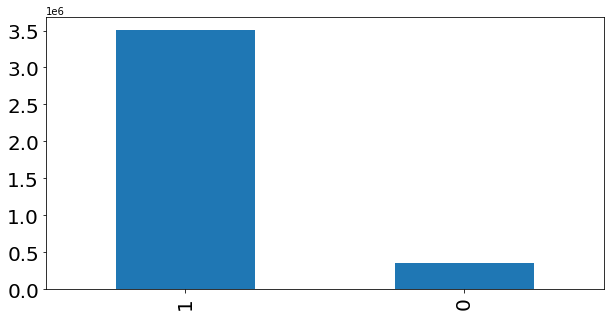

In [6]:
df.recognized.value_counts().plot(kind='bar', figsize=(10,5),  fontsize=20)

<center><b>Figure 3. Distribution of Recognized Drawings by the Quick, Draw! AI.</b></center>

### Visualizing the Sketches

To further imagine what the sketches look like, we used the `draw_strokes` function to visualize the sketch. See an example  of a `frog` sketch as shown in Figure 4. The shown sketches are the first stroke of three different sketches of a frog.

In [41]:
def draw_strokes(data, item=None, count=20):
    """Plot drawings."""
    
    data = data.reset_index(drop=True)
    plt.figure(figsize=(30,10))
    
    if item:
        for idx in list(data[data.word==item].index)[:count]:
            x = data.iloc[idx, 5: 90].values
            y = data.iloc[idx, 90:175].values
            plt.plot(x, y)
    else:
        for idx in list(data.index[:count])[:count]:
            x = data.iloc[idx, 5: 90].values
            y = data.iloc[idx, 90:175].values
            plt.plot(x, y)
            
    plt.title(item, fontsize=20)
    plt.show()
        
    return None

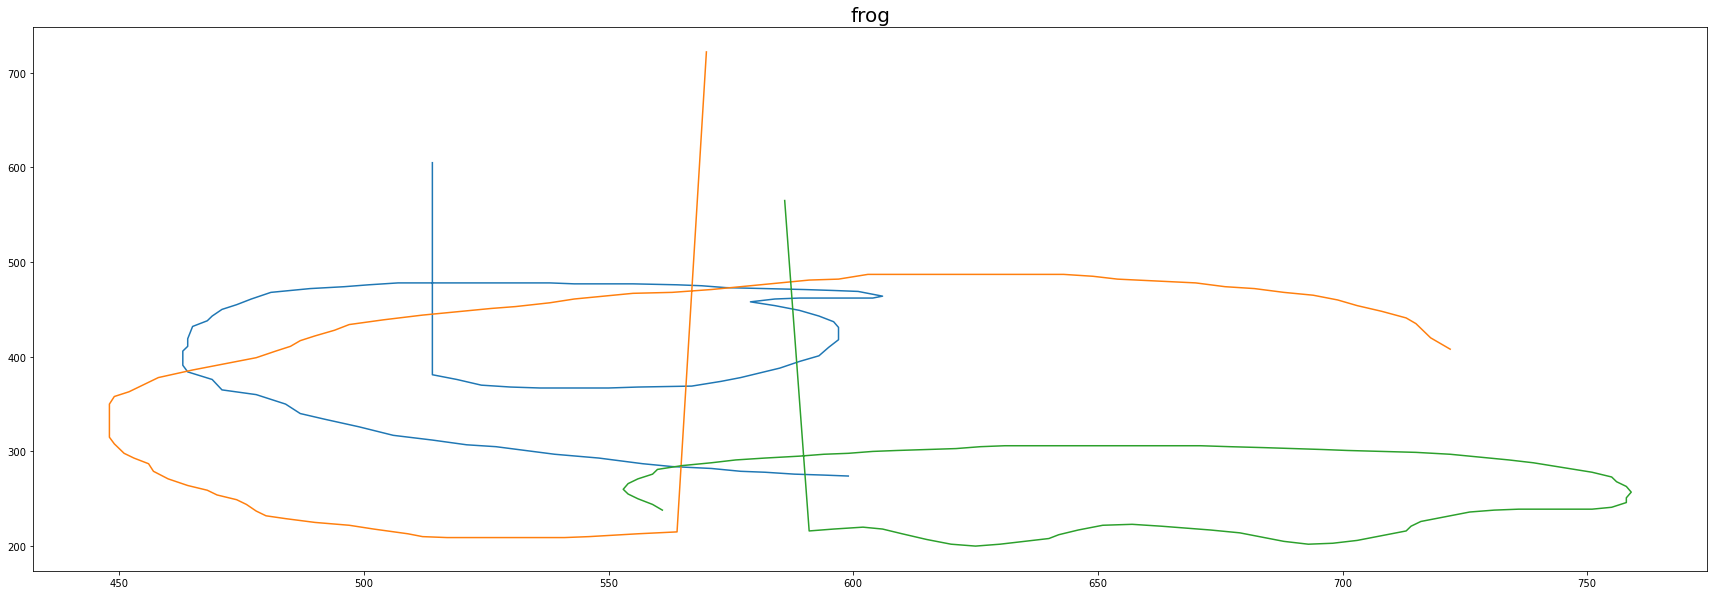

In [42]:
draw_strokes(df, item="frog", count=3)

<center><b>Figure 4. Sample sketches of the game.</b></center>

## 3. Sketch Prediction

This is where we develop a classification model for predicting the sketch based on the first stroke. This was done by using the `validate_clf` function to obtain classification model results. Our target variable was the `word` column and the rest were used features.  We used a 75-25 train-test split on the Random Forest Classifier Model as it is most efficient model to train this dataset.

In [44]:
def validate_clf(data, model, df_eval):
    """Return classification model evaluation results."""
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,5:],
                                                        data.word,
                                                        random_state = 42,
                                                        test_size = 0.25)
    model.fit(X_train, y_train)
    new_index = len(df_eval)
    df_eval.loc[new_index] = ['Random Forest Classifier',
                              model.get_params(),
                              model.score(X_train, y_train),
                              model.score(X_test, y_test)]
    display(df_eval)
    print()
    print(classification_report(y_true=y_test,
                                y_pred=model.predict(X_test),
                                output_dict=False))
    
    return (df_eval, classification_report(y_true=y_test,
                                y_pred=model.predict(X_test),
                                output_dict=True))


def draw_strokes(data):
    """Plot drawings."""
    for idx in list(data.index):
        x = data.iloc[idx, 2:152].values
        y = data.iloc[idx, 152:302].values

        plt.plot(x, y)
    plt.show()
        
    return None

In [45]:
# Run this to rest dataframe
cols = ['Classification Method',
        'Parameters',
        'Train Accuracy', 
        'Test Accuracy']
df_eval = pd.DataFrame(columns=cols)

To evaluate the model's performance, precision, recall and f-1 score were determined. After hyperparameter tuning our models parameters, we obtained model accuracy of $25.13\%$. This is a relatively good accuracy given that we are dealing with $81$ classes where each of the first stroke sketches belong to.

In [46]:
mod1 = RandomForestClassifier(n_estimators=100,
                              criterion='gini',
                              max_depth=18,
                              max_features='auto',
                              n_jobs=-1,
                              random_state=42)

df_eval, _crdict = validate_clf(df, mod1, df_eval)

,Classification Method,Parameters,Train Accuracy,Test Accuracy
0,Random Forest Classifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.496533,0.251262



              precision    recall  f1-score   support

         ant       0.00      0.00      0.00       971
       apple       0.19      0.60      0.29     19793
         arm       0.31      0.15      0.20     13605
   asparagus       0.35      0.51      0.42     13804
      banana       0.30      0.66      0.41     34167
         bat       0.21      0.15      0.17     10929
        bear       0.15      0.02      0.03      9597
         bee       0.12      0.02      0.03      4926
        bird       0.00      0.00      0.00      7049
  blackberry       0.25      0.22      0.23      7623
   blueberry       0.29      0.01      0.01      5258
       brain       0.21      0.27      0.23     19640
    broccoli       0.24      0.39      0.30     10791
   butterfly       0.35      0.19      0.24      8412
      carrot       0.32      0.34      0.33     11530
         cat       0.25      0.10      0.14      8124
         cow       0.13      0.00      0.01     10216
        crab       0.11   

<center><b>Table 4. Model Classification Results Without Grouping.</b></center>

To benchmark on how well our model performs, we computed for the Proportional Chance Criterion (PCC). Our model's accuracy of 25.13% is higher than 1.25xPCC at 2.11%.

#### PCC (sum of squared proportions)

In [47]:
# ALL
pcc = sum(((np.array(df.word.value_counts().values)) /
           df.word.value_counts().sum())**2)

print("[all items] PCC =", pcc)

[all items] PCC = 0.014770756235332954


In [48]:
print("[all items] 1.25*PCC =", 1.25*pcc)

[all items] 1.25*PCC = 0.021054705196165924


## 4. Grouping objects based on f-1 score

Even though our model already outperforms the 1.25 PCC, we also explored how to further improve its performance by grouping the categories that resulted to an f-1 score lower than 0.3. This evaluation metric was chosen as the basis for grouping as it accounts for both precision and recall which is its harmonic mean. The choice of f-1 score threshold is arbitrary. The intuition behind such action is that some classes have low f-1 score which means that first stroke sketches under such classes might be difficult to identify. Thus, they are wrongly classified to be under other classes. This also affects the f-1 score of other classes. Hence, placing classes with low f-1 score into a single placeholder may mitigate the issue of numerous wrongly classified sketches.

### Identifying objects with f-1 score < 0.3 based on results of previous classifier
After identifying all those objects that have f-1 score lower than 0.3, we tag them as `others` in the `word` columns.

In [50]:
others = [x for x,y in list(_crdict.items())[:81] if y['f1-score'] < 0.3]
print(len(others))
others

65


['ant',
 'apple',
 'arm',
 'bat',
 'bear',
 'bee',
 'bird',
 'blackberry',
 'blueberry',
 'brain',
 'broccoli',
 'butterfly',
 'cat',
 'cow',
 'crab',
 'crocodile',
 'dog',
 'dolphin',
 'elbow',
 'elephant',
 'eye',
 'face',
 'feather',
 'flower',
 'frog',
 'garden',
 'giraffe',
 'goatee',
 'grapes',
 'hedgehog',
 'horse',
 'kangaroo',
 'leaf',
 'lion',
 'lobster',
 'monkey',
 'mosquito',
 'mouse',
 'mouth',
 'nail',
 'onion',
 'owl',
 'palm tree',
 'panda',
 'parrot',
 'peanut',
 'peas',
 'penguin',
 'pig',
 'raccoon',
 'rhinoceros',
 'scorpion',
 'sea turtle',
 'shark',
 'sheep',
 'snake',
 'spider',
 'squirrel',
 'strawberry',
 'swan',
 'tiger',
 'toe',
 'tree',
 'watermelon',
 'whale']

In [52]:
df2 = df.replace(others, 'others')
df2.head()

,countrycode,recognized,word,stroke_num,stroke_length,x_0,x_1,x_2,x_3,x_4,...,y_76,y_77,y_78,y_79,y_80,y_81,y_82,y_83,y_84,y_85
0,US,1,others,11,106,970,965,960,955,950,...,477,476,475,472,469,466,463,460,455,450
1,IT,0,others,2,682,1460,1456,1453,1449,1446,...,1609,1621,1634,1643,1656,1673,1690,1707,1724,1737
2,US,1,others,7,95,344,339,332,327,321,...,193,193,193,193,193,193,193,193,193,195
3,ID,1,others,12,299,707,704,699,694,689,...,292,287,282,277,276,276,280,285,291,296
4,PT,1,others,8,86,898,893,885,880,871,...,350,350,350,350,350,350,350,350,350,350


<center><b>Table 5. Final Dataset with grouping.</b></center>

## 5. Improved Sketch Prediction

After tagging the objects  under classes with low f-1 score in the previous step as `others`, the number of categories is now **18** including the `others` category.  We then again develop a model using this dataset and the `validate_clf` function to find the performance of the classification model on a *less noisy* data. With this, we arrived at an accuracy of $75.19\%$, significantly higher than the previous accuracy without grouping. The intuition behind the significant increase in accuracy is that sketches that are hard to classify tend to fall under the `others` class. This means that there are some classes whose elements are recognizable even just with the first stroke.

In [53]:
df_eval, _crdict = validate_clf(df2, mod1, df_eval)

,Classification Method,Parameters,Train Accuracy,Test Accuracy
0,Random Forest Classifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.496533,0.251262
1,Random Forest Classifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.774022,0.751855



              precision    recall  f1-score   support

   asparagus       0.77      0.12      0.21     13804
      banana       0.77      0.20      0.31     34167
      carrot       0.90      0.02      0.04     11530
        duck       1.00      0.01      0.02     21695
         ear       0.77      0.01      0.02      8705
      finger       0.68      0.10      0.17     12687
        fish       0.95      0.10      0.19     24160
       grass       0.77      0.30      0.43     10348
 house plant       0.92      0.01      0.01      8393
        knee       0.70      0.06      0.11     13099
         leg       0.73      0.06      0.12      9900
   moustache       0.93      0.00      0.01     17065
        nose       0.95      0.01      0.03      8467
      others       0.75      1.00      0.86    707622
      rabbit       0.79      0.10      0.17     10674
       skull       0.87      0.03      0.06     17419
       snail       0.93      0.07      0.13     17132
       zebra       0.00   

<center><b>Table 6. Model Classification Results with grouping.</b></center>

We then computed the new 1.25xPCC of the new set of classes and got $68.13\%$ . Our model's accuracy still outperforms this at $75.19\%$ accuracy.

#### PCC (sum of squared proportions)

In [57]:
# with placeholder `others`
pcc2 = sum(((np.array(df2.word.value_counts().values)) /
           df2.word.value_counts().sum())**2)

print("[with placeholder `others`] = ", pcc2)

[with placeholder `others`] =  0.5450777586159167


In [58]:
print("[all items] 1.25*PCC2 =", 1.25*pcc2)

[all items] 1.25*PCC2 = 0.6813471982698959


<div><span style="background-color: #1F773B; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #F2FBF5; font-size: 20px; font-weight: bold">RESULTS & DISCUSSION</span></div>

The summary of results of our study with and without grouping can be found on the table below. This shows that our models performs well given that its test accuracy is higher than the $1.25 \times PCC$ and the *Quick, Draw!* AI for both with and without grouping.

<center><b>Table 4. Model Results.</b></center>

|Evaluation Metric|Without Grouping|With Grouping|
|:--|:--|:--|
|Model Accuracy|$25.13\%$|$75.19\%$|
|Quick, Draw! AI| $12.01\%$|N/A|
|$1.25 \times PCC$|$2.11\%$|$68.13\%$|


Note that the accuracy of the *Quick, Draw!* AI is based on the ratio of the number of recognized sketches in one stroke to the total number of recognized sketches in the data set.

<div><span style="background-color: #1F773B; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #F2FBF5; font-size: 20px; font-weight: bold">BUSINESS VALUE</span></div>

### Future of Sketch Prediction

This study can help in developing algorithms that will aid in the future of sketch prediction. Similar to a google search wherein you type some text and give google gives out suggestions, this study can pave the way in using drawing strokes to suggest possible drawings or images in the search.

### Tool for Online Learning

In these times, the pandemic led to an increase in the use of touch devices and smart phones, thus sketch recognition and completion will be beneficial especially for online learning. This will help the educators and students have a better learning experience when conveying their knowledge through sketching on their devices. 

<div><span style="background-color: #1F773B; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #F2FBF5; font-size: 20px; font-weight: bold">CONCLUSION & RECOMMENDATIONS</span></div>

Based on the results, we were able to develop a model that will predict a certain sketch based on first stroke. With an accuracy of 25.13% for without grouping and 75.19% without grouping, our model can predict sketches while outperforming  the 12.01% performance by Quick, Draw!’s AI. With this, we believe that the model can be integrated to Quick, Draw!’s underlying neural network to improve its speed in guessing a sketch.

For future studies, we recommend the following:
1. Expand the dataset by using other categories on the original dataset.
2. Use of different neural networks as model architectures might improve the model's performance.
3. Aside from prediction, auto completion of sketches can be explored.

<div><span style="background-color: #1F773B; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #F2FBF5; font-size: 20px; font-weight: bold">REFERENCES</span></div>

[1] Google Crealive Lab. (2017). Quick, Draw! Retrieved from https://experiments.withgoogle.com/quick-draw


[2] Kaggle. Quick, Draw! Doodle Recognition Challenge. Retrieved from https://www.kaggle.com/c/quickdraw-doodle-recognition/discussion/73738
